In [5]:
import matplotlib.pyplot as plt
from cycler import cycler

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 
for i in range(len(tableau20)):
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)
    

plt.rc('legend', frameon=True,fancybox=True,fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('grid', linestyle="--", color='grey',alpha = 0.2)
plt.rc('font', size=14, family='sans-serif',style='normal',weight='normal')
plt.rc('axes', labelsize=14, titlesize=14,
       titleweight='bold',prop_cycle=(cycler('color',tableau20)))

plt.rc('figure', figsize=(14, 8),titlesize=16)

In [2]:
import pandas as pd
import numpy as np
import datetime
import os
%matplotlib inline

import matplotlib as mpl
#import seaborn as sns

In [3]:
df = pd.read_pickle(os.path.join('data','quote=FING-BSSAB-B&start=2016-10-03&end=2017-10-02&interval=1440min.pkl'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 7 columns):
datetime    506 non-null datetime64[ns]
stock       506 non-null object
open        506 non-null float64
high        506 non-null float64
low         506 non-null float64
close       506 non-null float64
volume      506 non-null float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 27.8+ KB


open           high           low          close  \
stock                FING-B SSAB-B  FING-B SSAB-B FING-B SSAB-B  FING-B   
datetime                                                                  
2016-10-03 17:30:00  101.00  20.90  101.50  21.47  99.30  20.85   99.80   
2016-10-04 17:30:00  100.00  21.30  100.90  21.82  99.00  21.30   99.80   
2016-10-05 17:30:00  100.20  21.68  101.00  21.84  99.25  21.47  100.20   
2016-10-06 17:30:00   99.75  21.85   99.85  21.94  95.25  21.56   96.25   
2016-10-07 17:30:00   97.00  21.80   97.20  22.39  94.10  21.78   95.40   

                                volume             
stock               SSAB-B      FING-B     SSAB-B  
datetime                                           
2016-10-03 17:30:00  21.32   2840234.0  4630179.0  
2016-10-04 17:30:00  21.75   3377179.0  4041791.0  
2016-10-05 17:30:00  21.80   4156429.0  3391308.0  
2016-10-06 17:30:00  21.68  11570839.0  2261553.0  
2016-10-07 17:30:00  22.20   6092416.0  6582477.0

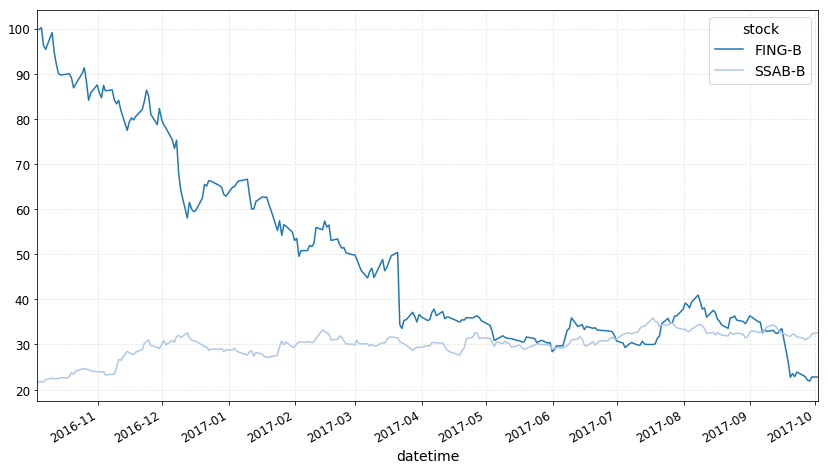

In [6]:
df_stock = df.groupby(['datetime','stock']).sum().unstack()
stocks = df_stock['close'].columns
df_stock['close'].plot(grid=True)
df_stock.head()

In [9]:
# ADD MEASURES

df_stock = df_stock.join(df_stock[['close']].div(df_stock['open'])
                         .sub(1).mul(100).rename(columns={'close':'x_open_close'}))
df_stock = df_stock.join(df_stock[['high']].div(df_stock['low'])
                         .sub(1).mul(100).rename(columns={'high':'x_low_high'}))
df_stock = df_stock.join(df_stock[['high']].div(df_stock['open'])
                         .sub(1).mul(100).rename(columns={'high':'x_open_high'}))
# SHIFT SINGLE
# open/close.shift(1) = GAP
# close/close.shift(1) = GAP + DAY CHANGE (WHAT YOU SEE)
df_stock = df_stock.join(df_stock[['open']].div(df_stock['close'].shift(periods=1))
                         .sub(1).mul(100).rename(columns={'open':'x_close_open'}))
df_stock = df_stock.join(df_stock[['close']].div(df_stock['close'].shift(periods=1))
                         .sub(1).mul(100).rename(columns={'close':'x_close_close'}))

for days in np.arange(1,11):
    # look at at days back total change
    df_stock = df_stock.join(df_stock[['close']].div(df_stock['open'].shift(periods=days))
                             .sub(1).mul(100).rename(columns={'close':'x_open_close_days_'+str(days)}))
    # Look at days back daily change
    df_stock = df_stock.join(df_stock[['close']].shift(periods=days).div(df_stock['close'].shift(periods=days+1))
                             .sub(1).mul(100).rename(columns={'close':'x_open_close_day_'+str(days)}))
    
#PREDICTORS, SHIFT BOTH BACK IN TIME, SEE IN FUTURE
#GAP FIRST DAY EXCLUDED SINCE CLOSE PRICE INCLUDED IN X (NO TIME TO TRADE)
# close.shift(-1)/open.shift(1) = NEXT DAY OUTCOME
# close.shift(-days)/open.shift(1) = NEXT X DAYS OUTCOME

for days in np.arange(1,11):
    df_stock = df_stock.join(df_stock[['close']].shift(periods=-days).div(df_stock['open'].shift(periods=-1))
                             .sub(1).mul(100).rename(columns={'close':'y_open_close_days_'+str(days)}))
    
df_stock.head()

open           high           low          close  \
stock                FING-B SSAB-B  FING-B SSAB-B FING-B SSAB-B  FING-B   
datetime                                                                  
2016-10-03 17:30:00  101.00  20.90  101.50  21.47  99.30  20.85   99.80   
2016-10-04 17:30:00  100.00  21.30  100.90  21.82  99.00  21.30   99.80   
2016-10-05 17:30:00  100.20  21.68  101.00  21.84  99.25  21.47  100.20   
2016-10-06 17:30:00   99.75  21.85   99.85  21.94  95.25  21.56   96.25   
2016-10-07 17:30:00   97.00  21.80   97.20  22.39  94.10  21.78   95.40   

                                volume               ...     \
stock               SSAB-B      FING-B     SSAB-B    ...      
datetime                                             ...      
2016-10-03 17:30:00  21.32   2840234.0  4630179.0    ...      
2016-10-04 17:30:00  21.75   3377179.0  4041791.0    ...      
2016-10-05 17:30:00  21.80   4156429.0  3391308.0    ...      
2016-10-06 17:30:00  21.68  11570839.0  2261553.0    ...      
2016-10-07 17:30:00  22.20   6092416.0  6582477.0    ...      

                    y_open_close_days_6           y_open_close_days_7  \
stock                            FING-B    SSAB-B              FING-B   
datetime                                                                
2016-10-03 17:30:00           -5.300000  4.976526           -8.000000   
2016-10-04 17:30:00           -8.183633  3.874539          -10.179641   
2016-10-05 17:30:00           -9.774436  2.425629          -10.075188   
2016-10-06 17:30:00           -7.525773  3.990826           -7.319588   
2016-10-07 17:30:00           -5.666317  1.530153           -5.561385   

                              y_open_close_days_8            \
stock                  SSAB-B              FING-B    SSAB-B   
datetime                                                      
2016-10-03 17:30:00  5.727700          -10.000000  5.070423   
2016-10-04 17:30:00  3.228782          -10.479042  4.566421   
2016-10-05 17:30:00  3.752860           -9.874687  3.249428   
2016-10-06 17:30:00  3.486239           -7.216495  5.229358   
2016-10-07 17:30:00  3.240324           -6.505771  6.930693   

                    y_open_close_days_9           y_open_close_days_10  \
stock                            FING-B    SSAB-B               FING-B   
datetime                                                                 
2016-10-03 17:30:00          -10.300000  6.431925           -10.100000   
2016-10-04 17:30:00          -10.279441  4.059041           -10.179641   
2016-10-05 17:30:00           -9.774436  4.988558           -10.676692   
2016-10-06 17:30:00           -8.144330  8.990826           -10.463918   
2016-10-07 17:30:00           -8.866737  5.400540            -7.974816   

                               
stock                  SSAB-B  
datetime                       
2016-10-03 17:30:00  5.915493  
2016-10-04 17:30:00  5.811808  
2016-10-05 17:30:00  8.741419  
2016-10-06 17:30:00  7.431193  
2016-10-07 17:30:00  8.460846  

[5 rows x 80 columns]

In [10]:
df_stock_swap = df_stock.swaplevel(axis=1)
df_stock_swap.head()

stock,FING-B,SSAB-B,FING-B,SSAB-B,FING-B,SSAB-B,FING-B,SSAB-B,FING-B,SSAB-B,...,FING-B,SSAB-B,FING-B,SSAB-B,FING-B,SSAB-B,FING-B,SSAB-B,FING-B,SSAB-B
,open,open,high,high,low,low,close,close,volume,volume,...,y_open_close_days_6,y_open_close_days_6,y_open_close_days_7,y_open_close_days_7,y_open_close_days_8,y_open_close_days_8,y_open_close_days_9,y_open_close_days_9,y_open_close_days_10,y_open_close_days_10
datetime,,,,,,,,,,,,,,,,,,,,,
2016-10-03 17:30:00,101.00,20.90,101.50,21.47,99.30,20.85,99.80,21.32,2840234.0,4630179.0,...,-5.300000,4.976526,-8.000000,5.727700,-10.000000,5.070423,-10.300000,6.431925,-10.100000,5.915493
2016-10-04 17:30:00,100.00,21.30,100.90,21.82,99.00,21.30,99.80,21.75,3377179.0,4041791.0,...,-8.183633,3.874539,-10.179641,3.228782,-10.479042,4.566421,-10.279441,4.059041,-10.179641,5.811808
2016-10-05 17:30:00,100.20,21.68,101.00,21.84,99.25,21.47,100.20,21.80,4156429.0,3391308.0,...,-9.774436,2.425629,-10.075188,3.752860,-9.874687,3.249428,-9.774436,4.988558,-10.676692,8.741419
2016-10-06 17:30:00,99.75,21.85,99.85,21.94,95.25,21.56,96.25,21.68,11570839.0,2261553.0,...,-7.525773,3.990826,-7.319588,3.486239,-7.216495,5.229358,-8.144330,8.990826,-10.463918,7.431193
2016-10-07 17:30:00,97.00,21.80,97.20,22.39,94.10,21.78,95.40,22.20,6092416.0,6582477.0,...,-5.666317,1.530153,-5.561385,3.240324,-6.505771,6.930693,-8.866737,5.400540,-7.974816,8.460846


### Explain Measures

In [257]:
def set_daily_xticks(df_date,ax,rot=0):
    major_ticks = pd.to_datetime(df_date.index.unique())
    major_tick_labels = list(map(lambda x: x.strftime('%a'), major_ticks))

    minor_ticks = list(filter(lambda x: x.dayofweek == 0, major_ticks))
    minor_tick_labels = list(map(lambda x: x.week, minor_ticks))

    ax.set_xticks(major_ticks, minor=False)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticklabels(major_tick_labels, minor=False, rotation=rot, ha='center',y=-0.03)
    ax.set_xticklabels(minor_tick_labels, minor=True, rotation=0, ha='center', weight='normal',alpha=1)
    
    ax.set_xlabel('')
    ax.grid()
    return ax

In [272]:
def add_measurement(df,x,m,ax,text=False,color='g'):
    y1 = df.loc[x[0]][m[0]]
    y2 = df.loc[x[1]][m[1]]
    if y2 < y1:
        text_color='r'
        color = 'r'
    else:
        text_color='g'
        color = 'g'
    d = {'datetime':x, text:[y1,y2]}
    df = pd.DataFrame(data=d).set_index('datetime')
    df.plot(marker='o', linestyle='--', color=color,ax=ax, legend=False,ms=6,alpha=1,lw=1)
    if text:
        text = str(round((y2/y1-1)*100,1))+'%'
        days = (x[1]-x[0]).days
        x_text = x[1]-pd.DateOffset(days=days/2)
        y_text = (y2+y1)/2
        ax.text(x_text, y_text, text,ha="center", va="center", color=text_color, bbox=dict(facecolor='white',ec=color,ls='--'))
    return ax

In [250]:
stock = 'SSAB-B'
days = 20
start_date = pd.to_datetime('2017-05-14')
df_sel = df_stock_swap[(df_stock_swap.index < start_date+pd.DateOffset(days=days)) &
                       (df_stock_swap.index >= start_date)][stock][['open','close','high','low']]

14


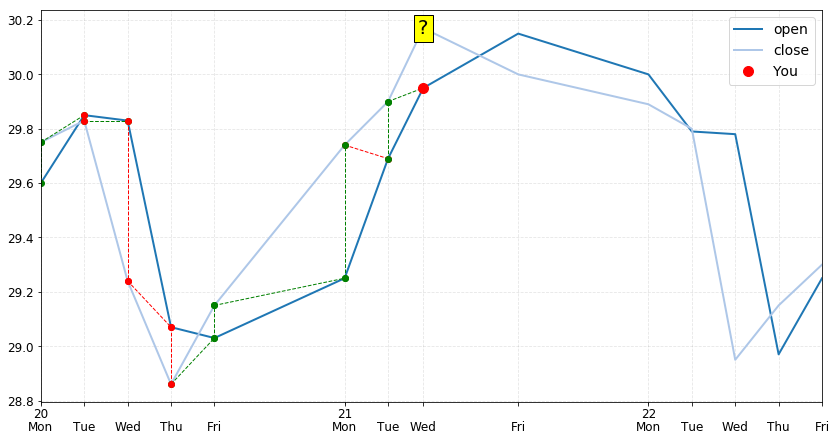

In [271]:
days = df_sel.shape[0]
print(days)
f, ax = plt.subplots(1,1)
df_sel[['open','close']].plot(lw=2,ax=ax)
d_day = 7
HIST = True
PRED = False
if HIST:
    for i in np.arange(0,d_day):
        x1 = df_sel.index[i]; x2 = df_sel.index[i+1]
        df_sel.pipe(add_measurement,x=[x1,x2],m=['close','open'],ax=ax,color='y',text=False)
        x1 = df_sel.index[i]; x2 = df_sel.index[i]
        df_sel.pipe(add_measurement,x=[x1,x2],m=['open','close'],ax=ax,color='y',text=False)
if PRED:
    for i in np.arange(d_day,d_day+1):
        x1 = df_sel.index[d_day]; x2 = df_sel.index[i]
        df_sel.pipe(add_measurement,x=[x1,x2],m=['open','close'],ax=ax,color='orange')

# YOU
df_sel.iloc[[d_day]]['open'].rename('You').plot(marker='o', linestyle='none', color='r',ax=ax, legend=True ,ms=10,alpha=1,lw=1)
# QUESTIONMARK
offset = 0
ax.text(x=df_sel.index[d_day+offset], y=df_sel.loc[df_sel.index[d_day+offset]]['close'], s='?',size=20,ha="center", va="center", bbox=dict(facecolor='yellow',ls='-'))

set_daily_xticks(df_sel,ax)

f.savefig('fig/'+stock+'-'+str(days)+'-hist-'+str(HIST)+'-pred-'+str(PRED)+'.png', dpi=100,bbox_inches='tight')

### Correlation

['x_close_close', 'x_close_open', 'x_low_high', 'x_open_close', 'x_open_close_day_1', 'x_open_close_day_10', 'x_open_close_day_2', 'x_open_close_day_3', 'x_open_close_day_4', 'x_open_close_day_5', 'x_open_close_day_6', 'x_open_close_day_7', 'x_open_close_day_8', 'x_open_close_day_9', 'x_open_close_days_1', 'x_open_close_days_10', 'x_open_close_days_2', 'x_open_close_days_3', 'x_open_close_days_4', 'x_open_close_days_5', 'x_open_close_days_6', 'x_open_close_days_7', 'x_open_close_days_8', 'x_open_close_days_9', 'x_open_high', 'y_open_close_days_1', 'y_open_close_days_10', 'y_open_close_days_2', 'y_open_close_days_3', 'y_open_close_days_4', 'y_open_close_days_5', 'y_open_close_days_6', 'y_open_close_days_7', 'y_open_close_days_8', 'y_open_close_days_9']


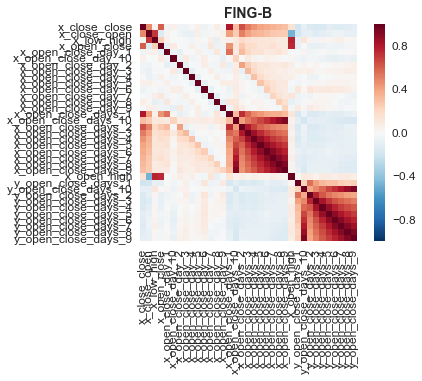

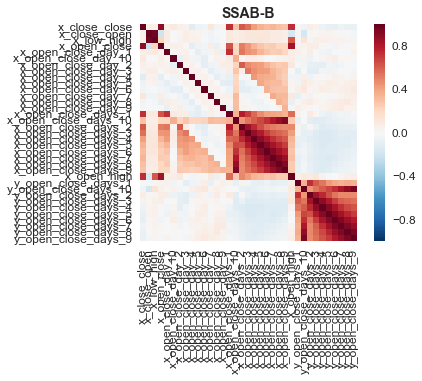

In [124]:
#CHECK CORRELATION BETWEEN MEASURES
import seaborn as sns

corr_var = [x for x in np.unique(df_stock.columns.get_level_values(level=0)) if 'x_' in x or 'y_' in x]
print(corr_var)
for stock in stocks:
    f, ax = plt.subplots(1,1)
    corr = df_stock_swap[stock][corr_var].corr()
    sns.heatmap(corr,square=True, ax=ax)
    ax.set_title(stock)
    f.savefig(stock+'.png', dpi=100,bbox_inches='tight')

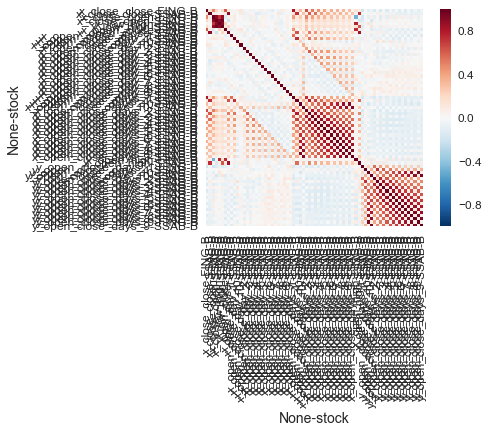

In [125]:
#CHECK CORRELATION BETWEEN MEASURES AND STOCKS!
import seaborn as sns

f, ax = plt.subplots(1,1)

corr = df_stock[corr_var].corr()
sns.heatmap(corr,square=True, ax=ax)

### What happened x days after a decline?

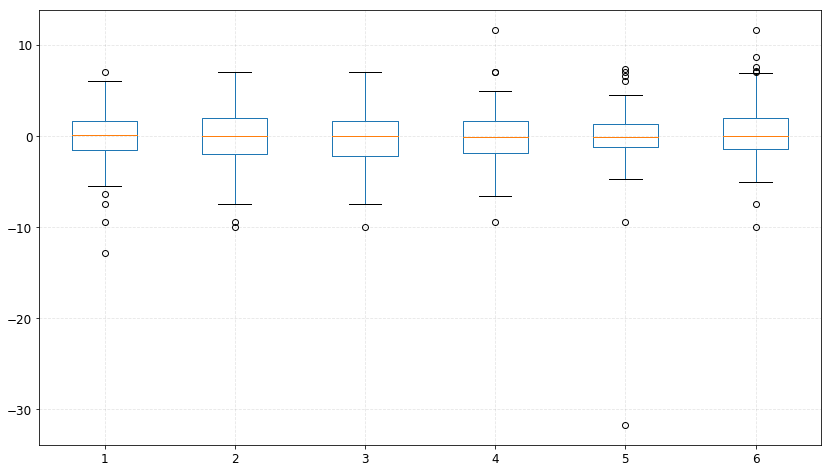

In [32]:
# DAY
x_days = 1
pct_change = -2
df_days = []
for x_days in [1,2,3,4,5,6]:
    df_temp = (
        df_stock['pct_close_close'][(df_stock['pct_close_close']<pct_change).shift(x_days).replace(np.nan,False)]
        .stack().rename(str(x_days)).reset_index()[str(x_days)]
    )
    df_days.append(df_temp)
df_days = pd.concat(df_days,axis=1)
df_days.plot(kind='box',grid=True)

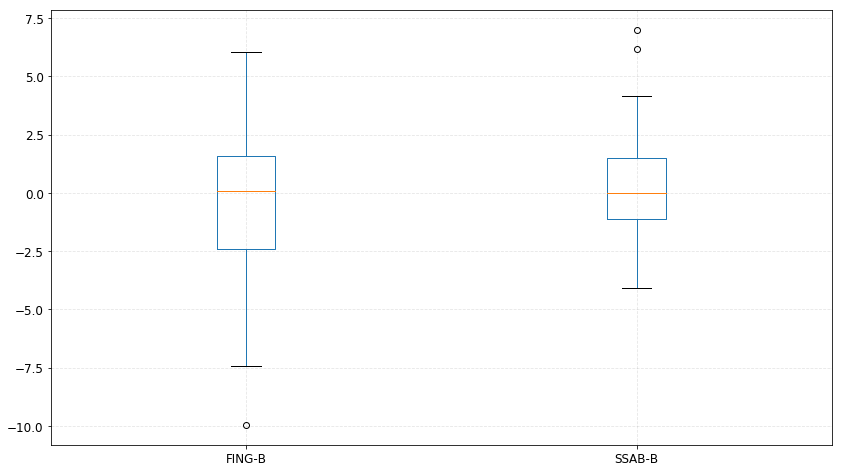

In [53]:
# STOCK
x_days = 3
df_stock['pct_close_close'][(df_stock['pct_close_close']<pct_change).shift(x_days).replace(np.nan,False)].plot(kind='box',grid=True)

0
1


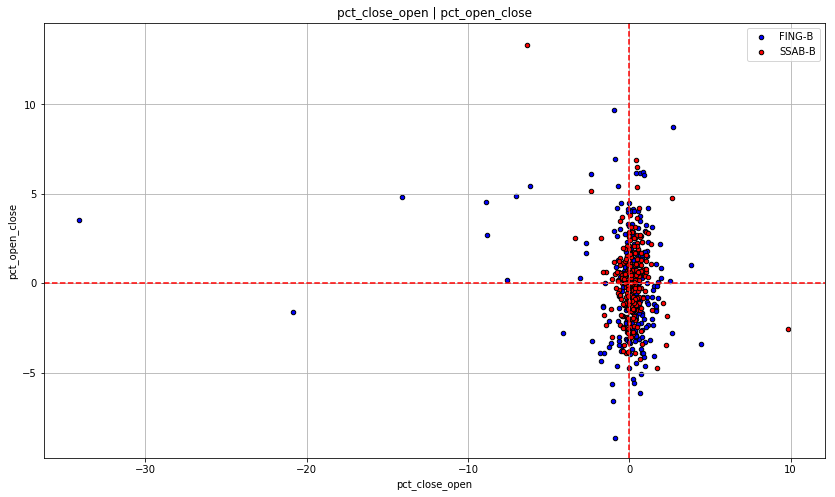

In [103]:
df_stock_swap = df_stock.swaplevel(axis=1)

# CLose price change dependancy
f, ax = plt.subplots(1,1)
x = 'pct_close_open'
y = 'pct_open_close'
colors = ['blue','red']
for nr,stock in enumerate(stocks):
    print(nr)
    df_sel = df_stock_swap[stock]
    df_sel.plot(ax=ax,kind='scatter',x=x,y=y,grid=True,s=20,color=colors[nr],edgecolor='black',title=x+' | '+y,legend=True)
ax.legend(stocks)
ax.axhline(0,ls = '--',color='red')
ax.axvline(0,ls = '--',color='red')